# Part 1 - Bootstrapping

In a medical study, doctors aimed to examine whether aspirin can reduce the incidents of heart attacks. To this aim, they recruited a large amount of subjects and divided them to aspirin group and placebo group. After receiving the aspirin or the placebo pill for a period of time, doctors observed that people in the aspirin group ended up only having 104 heart attacks incidents, and people in the placebo group ended up having 189 incidents.

Given the data, we can compute the percentages of the heart attack incident for both groups, and compute a ratio. The fact that the ratio is smaller than 1 suggests that aspirin therapy is effective in preventing heart attacks. But how sure are we of this estimate? Does the 95%
confidence interval include 1?

In [140]:
import numpy as np
from sklearn.linear_model import LinearRegression
from random import choices
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import sys
sys.path.append('/Users/hff/Desktop/NYU/5th year/Fall semester/MathTools/Labs/Lab9')
from scipy.io import loadmat
dataStruct = loadmat('regress1.mat')

np.random.seed(0)
cMAP1  = np.array([[50,205,50],[255,165,0]])/255

In [141]:
#------------------------YOUR CODE STARTS HERE-------------------------
#aspirin group
aspirin_heart   = 104
aspirin_total   = 11037
aspirin_data    = np.concatenate((np.ones(aspirin_heart), np.zeros(aspirin_total-aspirin_heart)))

#placebo group
placebo_heart   = 189
placebo_total   = 11034
placebo_data    = np.concatenate((np.ones(placebo_heart), np.zeros(placebo_total-placebo_heart)))

#Calculate statistic for original sample
ratio_empirical = (aspirin_heart/aspirin_total)/(placebo_heart/placebo_total)
print('The ratio computed from empirical data is ', str(ratio_empirical))

The ratio computed from empirical data is  0.5501149812103875


In [142]:
#Let's say we bootstrap (sample with replacement) 10,000 times
n_boot          = int(1e4)
#ratio_boot is used to store the ratio for each bootstrapped dataset
ratio_boot      = np.zeros(n_boot)
for i in range(n_boot):
    #resample aispiring data
    boot_asp         = choices(aspirin_data, k = aspirin_total)
    #resample placebo data 
    boot_placebo     = choices(placebo_data, k = placebo_total) 
    n_boot_asp       = np.sum(boot_asp)
    n_boot_placebo   = np.sum(boot_placebo) 
    #Calculate statistic for resampled data      
    ratio_boot[i]    = (n_boot_asp/aspirin_total)/(n_boot_placebo/placebo_total)

#Find 95% confidence interval
ratio_boot_sorted = np.sort(ratio_boot) # Sort ratio_boots from lowest to highest
lower_bound_ind   = int(np.ceil(0.025 * n_boot)) # Find index of 2.5% value
upper_bound_ind   = int(np.floor(0.975 * n_boot)) # Find index of 97.5% value

#Use lower/higher index to find value corresponding to 2.5%/97.5% position
lower_bound       = ratio_boot_sorted[lower_bound_ind]
upper_bound       = ratio_boot_sorted[upper_bound_ind]
#----------------------------------------------------------------------

Let's visualize the bootstrapped ratios and the 95% confidence interval.

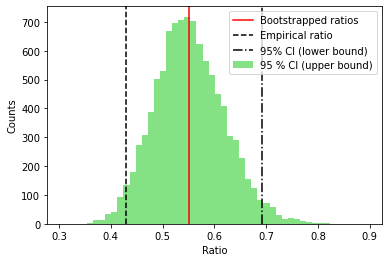

In [143]:
plt.figure()
plt.hist(ratio_boot, bins=50, color=cMAP1[0,], alpha=0.6)
plt.axvline(x=ratio_empirical, color='r', linestyle='-')
plt.axvline(x=lower_bound, color='k', linestyle='--')
plt.axvline(x=upper_bound, color='k', linestyle='-.')
plt.xlabel('Ratio'); plt.ylabel('Counts');
plt.legend(['Bootstrapped ratios', 'Empirical ratio', '95% CI (lower bound)',
    '95 % CI (upper bound)'])

The fact that the 95% confidence interval does not include 1 implies that we can be very confident that the aspirin therapy is effective in preventing heart attacks.

# Part 2 - Cross validation (leave-one-out)

Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. The goal of  cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting and to give an insight on how the model will generalize to a new (or unknown) dataset.

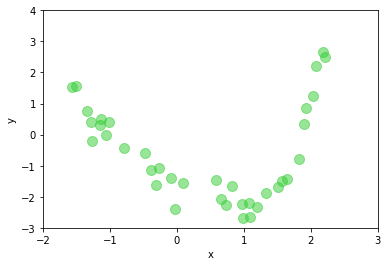

In [144]:
#let's first visualize the data
x = dataStruct['x'].T
y = dataStruct['y'].T

fig, ax = plt.subplots(nrows=1, ncols=1,figsize= (6,4))
plt.scatter(x, y, s = 100, color = cMAP1[0,], alpha = 0.5)
plt.xlim([-2,3]); plt.ylim([-3,4]); plt.xlabel('x')
plt.ylabel('y'); 

Now, we will fit the data with polynomial linear models without using cross validation. This will serve as a comparison to see how cross validation alters our interpretation of the 'best' model.

In [6]:
#Number of data points
n_pts    = y.shape[1]
x_zero   = np.ones([1,n_pts])
#All regressors that we will use for each fit
XX       = np.stack((x_zero[0], x[0], x[0]**2,x[0]**3,x[0]**4,x[0]**5,x[0]**6,
                     x[0]**7,x[0]**8,x[0]**9,x[0]**10,x[0]**11), axis = 0)
#Number of regressors (should be 6)
n_models = 12
order    = np.arange(0,n_models)
#initialize matrices mse_vec (which stores mean squared error) and fit_mat (which stores 
#predicted y values)
mse_vec  = []
fit_mat  = []

#------------------------YOUR CODE STARTS HERE-------------------------
#Loop through each polynomial order
for i in range(n_models):
    #Get betas for polynomial order
    betas = np.linalg.pinv(XX[0:(i+1)].T) @ y[0] #np.polyfit(x[0],y[0],i)
    #Get fit by multiplying betas with regressors
    print('Order = ' + str(i) + ', beta: ' + str(betas))
    fit   = XX[0:(i+1)].T @ betas #np.polyval(betas,x)
    #Add fit to fit matrix
    fit_mat.append(fit) 
    #Find and save mean square error
    mse = np.mean((y-fit)**2)
    mse_vec.append(mse)
#----------------------------------------------------------------------

Order = 0, beta: [-0.45680056]
Order = 1, beta: [-0.48709361  0.06749029]
Order = 2, beta: [-2.29410522 -0.85129482  1.26482851]
Order = 3, beta: [-1.7691334  -1.81629095  0.69101587  0.47760546]
Order = 4, beta: [-1.48158342 -1.15676217 -0.02729811  0.06652786  0.27353021]
Order = 5, beta: [-1.54500682 -1.05646781  0.18320403 -0.08144497  0.18429635  0.04899094]
Order = 6, beta: [-1.53314809 -0.9918027   0.13236256 -0.1729533   0.23101606  0.07609371
 -0.01255895]
Order = 7, beta: [-1.69201078 -1.05662204  1.29209429 -0.39323709 -0.95714849  0.43066629
  0.29165466 -0.11156957]
Order = 8, beta: [-1.64779652 -0.55000191  1.24004058 -1.82559722 -0.7366813   1.50270714
  0.02241086 -0.34629653  0.07821534]
Order = 9, beta: [-1.74963133 -0.73989337  2.31726088 -1.44158512 -2.69216733  1.47336128
  1.2128844  -0.54868503 -0.15417412  0.06748827]
Order = 10, beta: [-1.75154691 -0.56258978  2.55059189 -2.28155961 -3.08966968  2.6009384
  1.32890224 -1.13261805 -0.08557829  0.17085873 -0.0268

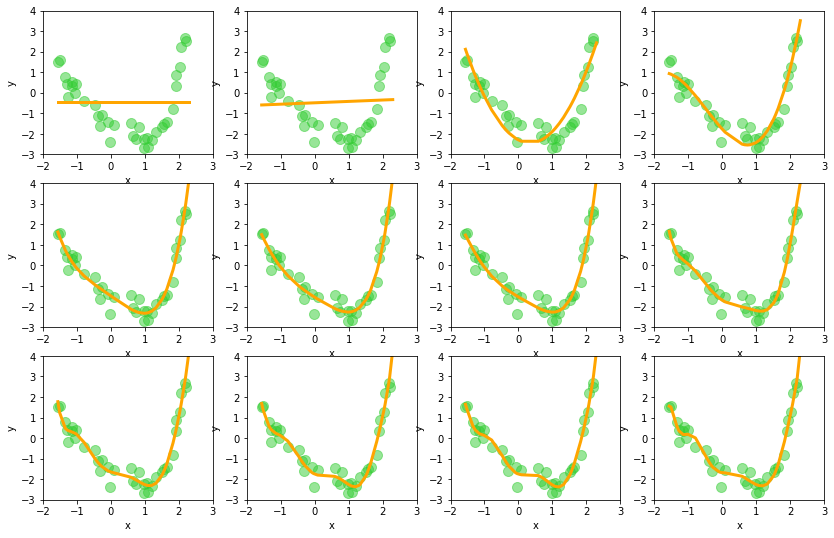

In [145]:
fig, ax = plt.subplots(nrows=3, ncols=4,figsize= (14,9))
for i in range(n_models):
    idx_row = i//4
    idx_col = i%4
    ax[idx_row, idx_col].scatter(x, y, s = 100, color = cMAP1[0,], alpha = 0.5)
    ax[idx_row, idx_col].plot(x[0], fit_mat[i], color = cMAP1[1,], linewidth = 3)
    ax[idx_row, idx_col].set_xlim([-2,3]); ax[idx_row, idx_col].set_ylim([-3,4]); 
    ax[idx_row, idx_col].set_xlabel('x'); ax[idx_row, idx_col].set_ylabel('y'); 

Next let's re-do the model fitting with leave-one-out cross validation and then re-evaluate our models.

In [146]:
#Let's fit this data with polynomials:

#------------------------YOUR CODE STARTS HERE-----------------------------
#Initialize a matrix to hold MSE values for each model for each cross validation
mse_train = np.zeros([n_models, n_pts])
mse_test  = np.zeros([n_models, n_pts])
for i in range(n_models): 
    mse_xval_i = []
    for j in range(n_pts):
        #Make j the test set
        idx_slc = list(range(n_pts)); idx_slc.remove(j)
        x_train = XX[0:(i+1),idx_slc]
        x_test  = XX[0:(i+1),j]
        
        y_train = y[0][idx_slc]
        y_test  = y[0][j]
        
        #Compute the fit (Get betas using training data)
        betas         = np.linalg.pinv(x_train.T) @ y_train
        fit_train     = x_train.T @ betas
        mse_train[i][j] = np.mean((y_train - fit_train)**2)
        
        #Test the fit (Get model's prediction for test point)
        fit_test       = np.dot(x_test, betas)
        mse_test[i][j] = np.mean((y_test - fit_test)**2) #MSE of test fit

#find lowest MSE
mean_mse_test = np.mean(mse_test,1)
min_mse       = np.min(mean_mse_test)
min_ind       = np.argmin(mean_mse_test)
mean_mse_train = np.mean(mse_train,1)
#----------------------------------------------------------------------------

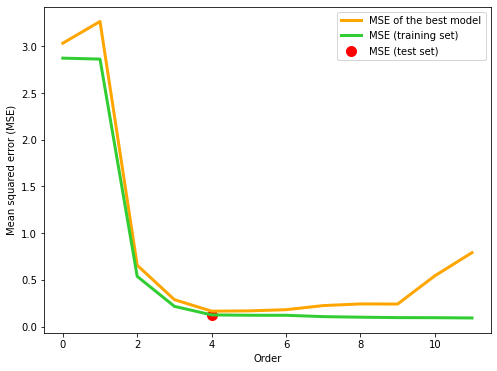

The best model is when order = 4


In [147]:
#Plot the mean MSE 
fig, ax = plt.subplots(nrows=1, ncols=1,figsize= (8,6))
plt.scatter(min_ind, mean_mse_train[min_ind], s = 100, c = 'red')
plt.plot(order, mean_mse_test, color = cMAP1[1],ls = '-', lw=3, ms=5)
plt.plot(order, mean_mse_train, color = cMAP1[0],ls = '-', lw=3, ms=5)
plt.xlim([-0.5,n_models-0.5]);  plt.xlabel('Order')
plt.ylabel('Mean squared error (MSE)')
plt.legend(['MSE of the ''best'' model','MSE (training set)', 'MSE (test set)'])
plt.show()

#Which model is best?
print('The best model is when order = ' + str(order[min_ind]))


# Part 3 - Model Comparison (AIC, BIC)
In this section, we will fit a psychometric function to simulated data, and compute AIC/BIC using the negative log likelihood.

In [148]:
#first load the fake data
dataStruct2 = loadmat('TOJ_fakeData.mat')

#t_diff represents SOA (the timing of the auditory 
#stimulus - the timing of the visual stimulus in ms). Positive values 
#represent the visual stimulus coming before the auditory stimulus; 
#negative values represent the auditory stimulus coming first. Like in a
#real experiment, all the SOA's are randomized.
t_diff    = dataStruct2['fakeData'][0][0][0]

#bool_V1st stores binary responses
#1: V first; 0: A first
bool_V1st = dataStruct2['fakeData'][0][1][0]

#we can also code the responses in the opposite way
#1: A first; 0: V first
#(this becomes handy when you compute negative log likelihood later on) 
bool_V2nd = 1 - bool_V1st

#before fitting, let's visualize the fake data
s_unique  = np.unique(t_diff) #unique SOA's
lenS      = len(s_unique) #the number of unique SOA's 
nTTrials  = len(t_diff) #number of total trials
numTrials = nTTrials/lenS #number of trials per level

#As in a real experiment, all the SOA's are randomized. We want to
#visualize the proportion of V-first responses as a function of SOA, so we
#have to first organize the responses. We do so by storing responses for
#the same SOA in one row.
r_org       = np.zeros([lenS, int(numTrials)])
for i in range(lenS): r_org[i,:] = bool_V1st[t_diff == s_unique[i]]
#compute the number of V-first responses for each SOA
nT_V1st      = np.sum(r_org,1)
#compute the proportion of V-first responses for each SOA
P_V1st       = nT_V1st/numTrials

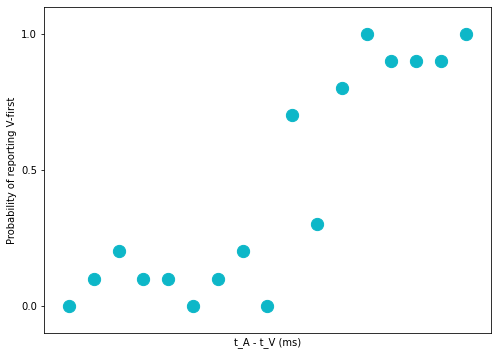

In [149]:
#Plotting starts here
cMAP = np.array([[200, 40, 40],[255, 128, 0], [13, 183, 200]])/255

fig, ax = plt.subplots(nrows=1, ncols=1,figsize= (8,6))
plt.scatter(s_unique, P_V1st, s = 150, color = cMAP[2])
plt.xlim([-450, 450]); plt.ylim([-0.1,1.1]); plt.xlabel('t_A - t_V (ms)')
plt.ylabel('Probability of reporting ''V-first'''); plt.xticks(s_unique[0:2:-1])
plt.yticks([0,0.5,1]); 

## Let's test three hypothesized models:

M1: we assume that this participant does not have any bias (i.e., PSS corresponds to a difference of 0 in time). Additionally, we assume that this participant is always attentive to the stimuli (i.e., lapse rate = 0). The only unknown free parameter we need to measure is sigma (the slope of the psychometric curve).

M2: we assume that this participant has a bias (i.e., the physical temporal difference has to be nonzero for him/her to perceive simultaneity. As in M1, this participant is assumed to pay attention to the task all the time. Therefore, this model has two free parameters, the center and the slope of the psychometric curve. 

M3: we assume that this participant occassionally made mistakes during the experiment (i.e., nonzero lapse rate). This model has three free parameters, the center and the slope of the psychometric curve as well as the lapse rate.

Note that these three models are NESTED!!!

In [86]:
#------------------------YOUR CODE STARTS HERE-----------------------------
#Let's test three models:
numM     = 3 #number of models
numP     = [1,2,3] #number of free parameters for M1, M2, M3 respectively
M1       = lambda x,p: norm.cdf(x, 0, p) 
M2       = lambda x,p: norm.cdf(x, p[0], p[1])
M3       = lambda x,p: p[2]/2 + (1-p[2])*norm.cdf(x, p[0], p[1])
fmat     = [M1, M2, M3] 

#define upper and lower bounds
lb       = [[80], [-50, 80], [ -50, 80, 1e-1]]
ub       = [[200], [150, 200], [150, 200, 0.2]]
bds      = [(80,200), ((-50,150),(80,200)), ((-50,150),(80,200),(1e-1,0.2))]
init_fun = lambda a,b: np.random.rand(len(a))*(np.array(b)-np.array(a)) + a

min_NLL, L_test,AIC, BIC = np.zeros(numM), np.zeros(numM), np.zeros(numM), np.zeros(numM)
estP     = []

#loop through the three models
for m in range(numM):
    #the initial point for matlab to start searching
    init = tuple(init_fun(lb[m], ub[m]))
    #negative log likelihood
    nLogL = lambda p: -np.dot(bool_V1st,np.log(fmat[m](t_diff, p))) -\
                       np.dot(bool_V2nd,np.log(1-fmat[m](t_diff, p)))
    #use minimize to fit
    if m == 0:
        fits = minimize(nLogL, ((init),), method = 'L-BFGS-B', bounds = (bds[m],))
    else: fits = minimize(nLogL, init, method = 'L-BFGS-B', bounds = (bds[m]))
    
    min_NLL[m] = fits.fun
    estP.append(fits.x)
    #compute the AIC/BIC
    AIC[m] = 2*min_NLL[m] + 2*numP[m]
    BIC[m] = 2*min_NLL[m] + numP[m]*np.log(nTTrials)
#--------------------------------------------------------------------------

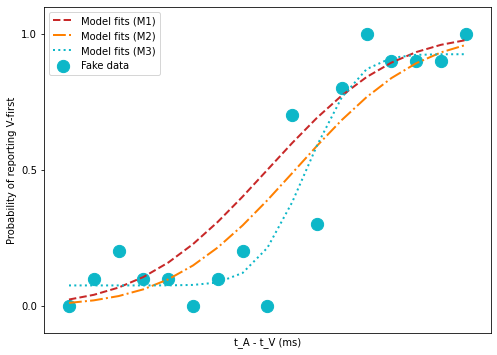

In [91]:
#plot the data along with the model fits
lstyle = ['--','-.',':']
cMAP = np.array([[200, 40, 40],[255, 128, 0], [13, 183, 200]])/255

fig, ax = plt.subplots(nrows=1, ncols=1,figsize= (8,6))
plt.scatter(s_unique, P_V1st, s = 150, color = cMAP[2])
for m in range(numM):
    predP = fmat[m](s_unique, estP[m])
    plt.plot(s_unique, predP, color = cMAP[m], linewidth = 2, linestyle = lstyle[m])
plt.xlim([-450, 450]); plt.ylim([-0.1,1.1]); plt.xlabel('t_A - t_V (ms)')
plt.ylabel('Probability of reporting ''V-first'''); plt.xticks(s_unique[0:2:-1])
plt.yticks([0,0.5,1]); plt.legend(['Model fits (M1)', 'Model fits (M2)',
                                   'Model fits (M3)', 'Fake data'])
plt.show()


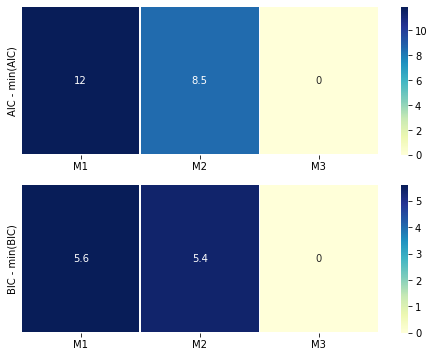

In [101]:
#plot AIC BIC
fig, axes = plt.subplots(nrows=2, ncols=1,figsize= (8,6))

sns.heatmap([AIC - np.min(AIC)], linewidth=0.5, ax = axes[0],cmap="YlGnBu",annot=True,linewidths=.5)
sns.heatmap([BIC - np.min(BIC)], linewidth=0.5, ax = axes[1],cmap="YlGnBu",annot=True,linewidths=.5)
axes[0].set_ylabel('AIC - min(AIC)');axes[1].set_ylabel('BIC - min(BIC)')
axes[0].set_xticklabels(['M1','M2','M3']); axes[1].set_xticklabels(['M1','M2','M3'])
axes[0].set_yticks([]); axes[1].set_yticks([]); plt.show() 


# Part 4 - AIC/BIC vs. Cross validation

In [150]:
#Leave-one-out cross validation starts here
min_NLL_LOOCV, L_test_LOOCV = np.zeros([numM, nTTrials]), np.zeros([numM, nTTrials])

#------------------------YOUR CODE STARTS HERE-----------------------------
#loop through all the trials
for i in range(nTTrials):
    #display the counter see where we are at (ends at 169)
    #print(i)   
    
    #select the trial indices
    idx_slc       = list(range(nTTrials)); idx_slc.remove(i)
    #selected SOA's
    t_diff_slc    = t_diff[idx_slc]
    t_diff_test   = t_diff[i]

    #selected response
    bool_V1st_slc = bool_V1st[idx_slc]
    bool_V2nd_slc = 1 - bool_V1st[idx_slc]
    
    #loop through all the three models
    for m in range(numM):
        #the initial point for matlab to start searching
        init   = init_fun(lb[m], ub[m])
        #negative log likelihood
        nLogL  = lambda p: -np.dot(bool_V1st_slc,np.log(fmat[m](t_diff_slc, p))) -\
                       np.dot(bool_V2nd_slc,np.log(1-fmat[m](t_diff_slc, p)))
        #use minimize to fit
        if m == 0:
            fits = minimize(nLogL, ((init),), method = 'L-BFGS-B', bounds = (bds[m],))
        else: fits = minimize(nLogL, init, method = 'L-BFGS-B', bounds = (bds[m]))
        
        min_NLL_LOOCV[m,i] = fits.fun
        estP.append(fits.x)
        
        #compute the likelihood of 
        L_test_LOOCV[m,i] = np.exp(-fmat[m](t_diff_test, estP[-1]))
#-------------------------------------------------------------------------------

In [151]:
#This part of the code shows you the results of cross-validation. 
#No changes are required.

#define a function that find 95% confidence intervals
get95CI      = lambda v,n: [v[int(np.ceil(0.025*n))], v[int(np.floor(0.975*n))]]
#compare the likelihood of M3 with that of M2
Lratio_M3_M2 = L_test_LOOCV[2]/L_test_LOOCV[1]
#compare the likelihood of M3 with that of M1
Lratio_M3_M1 = L_test_LOOCV[2]/L_test_LOOCV[0]
#compare the likelihood of M2 with that of M1
Lratio_M2_M1 = L_test_LOOCV[1]/L_test_LOOCV[0]
#put them together
Lratio       = [Lratio_M3_M2,Lratio_M3_M1,Lratio_M2_M1]

#print out the proportion of each likelihood ratio greater than 1
print('p(Likelihood ratio btw M3 & M2 > 1) = ' + str(np.sum(Lratio_M3_M2>1)/nTTrials))
print('p(Likelihood ratio btw M3 & M1 > 1) = ' + str(np.sum(Lratio_M3_M1>1)/nTTrials))
print('p(Likelihood ratio btw M2 & M1 > 1) = ' + str(np.sum(Lratio_M2_M1>1)/nTTrials))

p(Likelihood ratio btw M3 & M2 > 1) = 0.48823529411764705
p(Likelihood ratio btw M3 & M1 > 1) = 0.6941176470588235
p(Likelihood ratio btw M2 & M1 > 1) = 1.0


In [127]:
Lratio_CI, Lratio_mean = [],[]
for i in range(numM):
    Lratio[i].sort()
    #call get95CI.m for computing confidence intervals
    Lratio_CI.append(get95CI(Lratio[i], nTTrials))
    #compute the mean likelihood ratio
    Lratio_mean.append(np.mean(Lratio[i]))


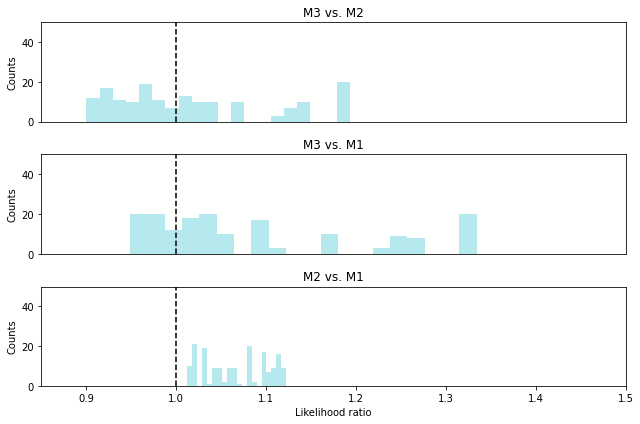

In [139]:
#plot histograms for likelihood ratios
edg = np.arange(0.85,1.5,0.02)
fig, axes = plt.subplots(nrows=3, ncols=1,figsize= (9,6))
for i in range(numM):
    axes[i].hist(Lratio[i], bins = 20, color= cMAP[2], alpha=0.3)
    axes[i].axvline(x = 1, color='k', linestyle='--')
    axes[i].set_xlim([0.85, 1.5]); axes[i].set_ylim([0, 50])
    axes[2].set_xlabel('Likelihood ratio'); axes[i].set_ylabel('Counts')
axes[0].set_title('M3 vs. M2'); axes[1].set_title('M3 vs. M1'); axes[2].set_title('M2 vs. M1'); 
axes[0].set_xticks([]); axes[1].set_xticks([]);
plt.tight_layout()